I have used this source as inspiration to implemement the follwoing MLP-HOG model - https://duchesnay.github.io/pystatsml/auto_gallery/ml_lab_face_recognition.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Face-Emotion-Recognition-Project' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['MLP-HOG train .ipynb', 'SIFT_MLP.ipynb', '.gitignore', 'LICENSE', 'README.md', 'src', 'models', 'personal_dataset', '.git', '.vscode', '__pycache__', 'CW_Dataset', 'train_hog_naive_bayes.ipynb', 'train_function.ipynb', 'hyper-parameter-tuning and training models.ipynb', 'SVM-SIFT train dummy.ipynb', 'References .gdoc', '.ipynb_checkpoints', 'SVM-HOG train dummy.ipynb', 'Copy of SVM-SIFT train dummy.ipynb', 'Data Exploration.ipynb', 'train_sift_naive_bayes.ipynb', 'Pre-trained CNN and MLP training.ipynb', 'test_function.ipynb', 'Copy of SVM-HOG train dummy.ipynb']


In [ ]:
import sys
modules_needed = ['models','models/feature_descriptors','models/lib','src']
for i in modules_needed:
  if i not in sys.path:
    CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH,i )
    sys.path.append(CODE_PATH)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
zip_path = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
from data_loader import import_selected_data, shuffleData
from preprocessing import *
from collections import  Counter
import numpy as np


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 89kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import cv2
from skimage import img_as_ubyte, io, color
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score


In [ ]:
X_train,y_train = import_selected_data('train')
X_train, y_train = shuffleData(X_train, y_train)

In [ ]:
print(Counter(y_train))
len(y_train)

Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281})


12271

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

In [ ]:
from hog_descriptor import HOG_DESCRIPTOR

In [ ]:
hog_obj = HOG_DESCRIPTOR()

In [ ]:
hog_obj.compute_hog_descriptors(X_train,y_train)

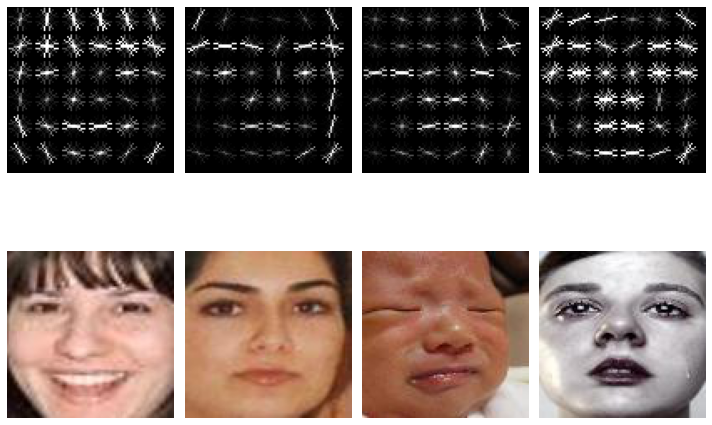

In [ ]:
hog_obj.show_hog_images()

In [ ]:
len(hog_obj.y_list) == len(y_train)

True

In [ ]:
hog_obj.des_array.shape

(12271, 288)

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from time import time
import numpy as np

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [ ]:
mlp_params= {"hidden_layer_sizes":
                 [(150,100,50,25, ), (100, 50, 25, ), (50, 25, 15, ), (25, 15, 5, )],
                  "activation": ["relu"], "solver": ["adam"], 'alpha': [0.0001,0.001],
                  "batch_size":[1000]
             
             }

In [ ]:
pipe = make_pipeline(SMOTE(sampling_strategy={2:700}),RandomUnderSampler(sampling_strategy = {4:1000, 7:1000}), preprocessing.StandardScaler(), MLPClassifier(max_iter=400))

In [ ]:
new_params = {'mlpclassifier__' + key: mlp_params[key] for key in mlp_params}

In [ ]:
mlp_grid_cv = GridSearchCV(pipe, param_grid=new_params,verbose=3,n_jobs=-1, cv = cv )

In [ ]:
hog_features = hog_obj.des_array

In [ ]:
time_initial = time()
mlp_grid_cv.fit(hog_features,y_train)
print("done in %0.3fs" % (time() - time_initial))

Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 16.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


done in 992.117s


In [ ]:
mlp_grid_cv.best_score_

0.5130796278129945

In [ ]:
mlp_grid_cv.best_params_

{'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.001,
 'mlpclassifier__batch_size': 1000,
 'mlpclassifier__hidden_layer_sizes': (100, 50, 25),
 'mlpclassifier__solver': 'adam'}

In [ ]:
from joblib import dump, load

In [ ]:
filename = os.path.join(GOOGLE_DRIVE_PATH, 'models/lib/trained_hog_mlp.joblib')
dump(mlp_grid_cv,filename)

['drive/My Drive/Colab Notebooks/Face-Emotion-Recognition-Project/models/lib/trained_hog_mlp.joblib']

In [ ]:
X_test, y_test = import_selected_data('test')

In [ ]:
hog_test_obj = HOG_DESCRIPTOR()

In [ ]:
hog_test_obj.compute_hog_descriptors(X_test,y_test)


In [ ]:
test_hog_features = hog_test_obj.des_array

In [ ]:
predicted = mlp_grid_cv.predict(test_hog_features).tolist()

In [ ]:
from sklearn.utils import shuffle


In [ ]:
print(f"""Classification report for classifier {mlp_grid_cv}:
      {metrics.classification_report(y_test, predicted)}\n""")

Classification report for classifier GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy={2: 700},
                                              svm_estimator='deprecated')),
                                       ('randomundersampler',
                                        RandomUn...
             iid='deprecated', n_jobs=-1,
             param_grid={'mlpclassifier__activation': ['relu'],
                         'mlpclassifier__alpha': [0.0001, 0.001],
             

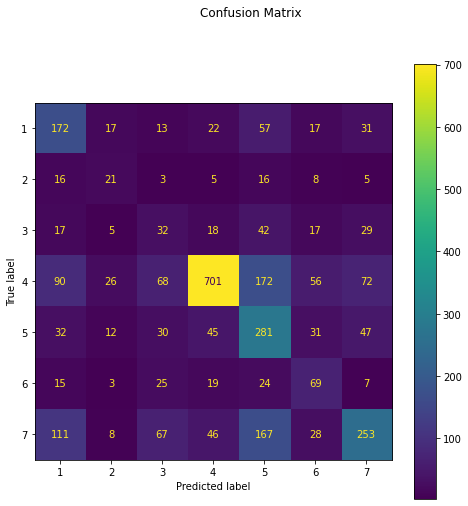

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = metrics.plot_confusion_matrix(mlp_grid_cv, list(test_hog_features), y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

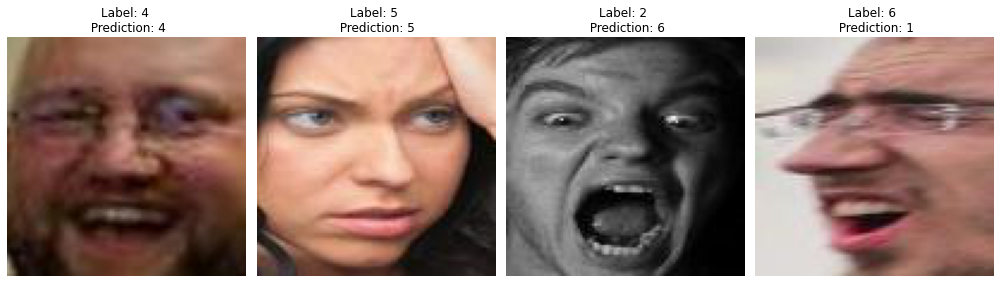

In [ ]:
X_test, y_test, predicted = shuffle(X_test , y_test, predicted)
#X_test_img = X_test.reshape(-1, 100, 100)


fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(4):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
cohen_kappa_score = cohen_kappa_score(y_test,predicted)

In [ ]:
cohen_kappa_score

0.3706985401182592